## **Задание**

1. Выберите ряд из первого задания.
2. Постройте его модель ARIMA.
3. Оформите отчёт в Jupyter-ноутбук.

**Дополнительное задание***  
Попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
%matplotlib inline

In [2]:
from statsmodels.tsa.arima.model import ARIMA

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
dowjones_closing = pd.read_csv("../Series/weekly-closings-of-the-dowjones-.csv")

In [5]:
data = dowjones_closing.Close

#### Выбираем небольшой горизонт предсказания, поскольку на рынке акций возможно применение временных рядов на далёком горизонте не так эффективно

In [6]:
train_data = data[:len(data)-5]
test_data = data[len(data)-5:]

### Берём произвольные p, d, q

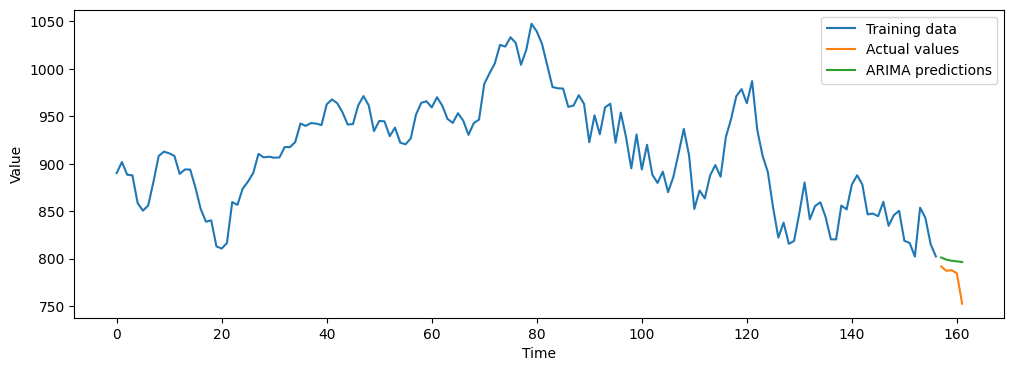

In [7]:
model = ARIMA(train_data, order = (3,2,1))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end = len(train_data)+len(test_data)-1)

plt.figure(figsize=(12,4))
plt.plot(train_data, label='Training data')
plt.plot(test_data.index, test_data, label='Actual values')
plt.plot(test_data.index, predictions, label='ARIMA predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Первый "выстрел" не удачный)))

### Попробуем найти оптимальное соотношение p, d, q на train выборке и посмотрим какое будет предсказание на тестовой выборке

In [8]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(7):
    for d in range(7):
        for j in range(7):
            try:
                tmp_mdl = ARIMA(train_data, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 1374.41265 | order: (2, 2, 3)


### Как видно ниже на графике первое предсказание довольно близко к фактическому значению, но после следующих 2 модель не смогла правильно предсказать падение  индекса.

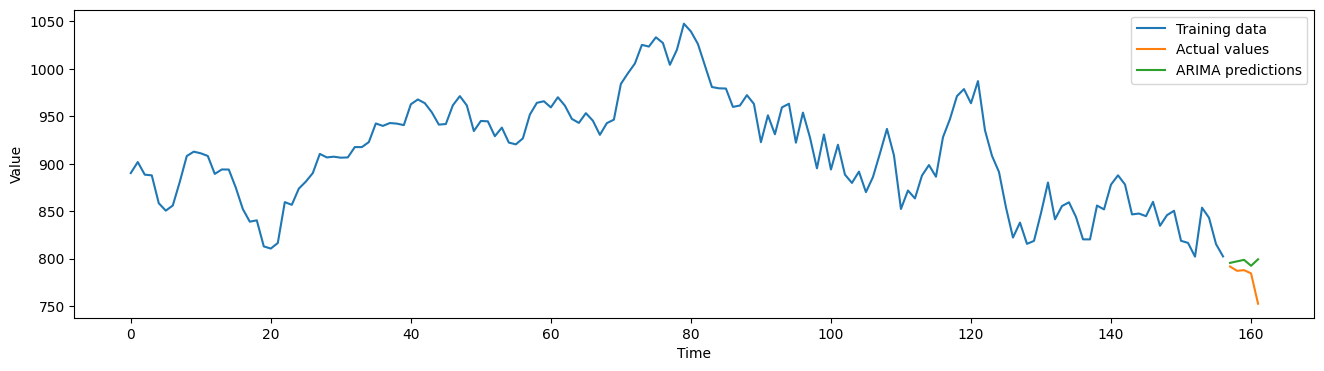

In [9]:
model = ARIMA(train_data, order = best_order)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end = len(train_data)+len(test_data)-1)

plt.figure(figsize=(16,4))
plt.plot(train_data, label='Training data')
plt.plot(test_data.index, test_data, label='Actual values')
plt.plot(test_data.index, predictions, label='ARIMA predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Посмотрим как, в целом, модель показывает себя по отношению к фактическим train data.

In [10]:
model = ARIMA(train_data, order = best_order)
model_fit = model.fit()

In [11]:
predictions = model_fit.predict(typ='levels')

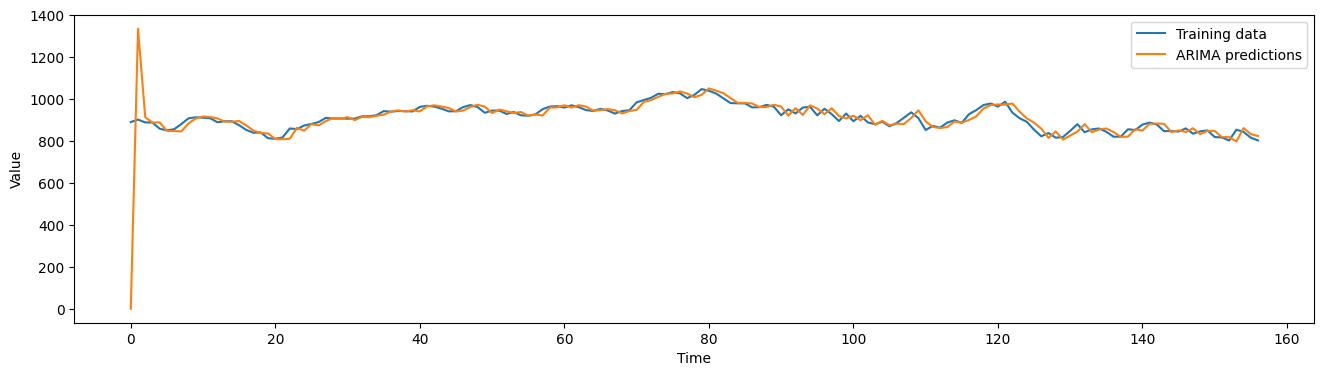

In [12]:
plt.figure(figsize=(16,4))
plt.plot(train_data, label='Training data')
plt.plot(train_data.index, predictions, label='ARIMA predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### За исключением первых значений, когда у модели не было значений для предсказания, в целом, она близка к фактическим данным.  

Далее проверим на стационарность.

In [13]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [14]:
def tsplot(y, lags=None, figsize=(14, 12), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                 -52.030733
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    156.000000
Critical Value (1%)             -3.472979
Critical Value (5%)             -2.880252
Critical Value (10%)            -2.576747
dtype: float64


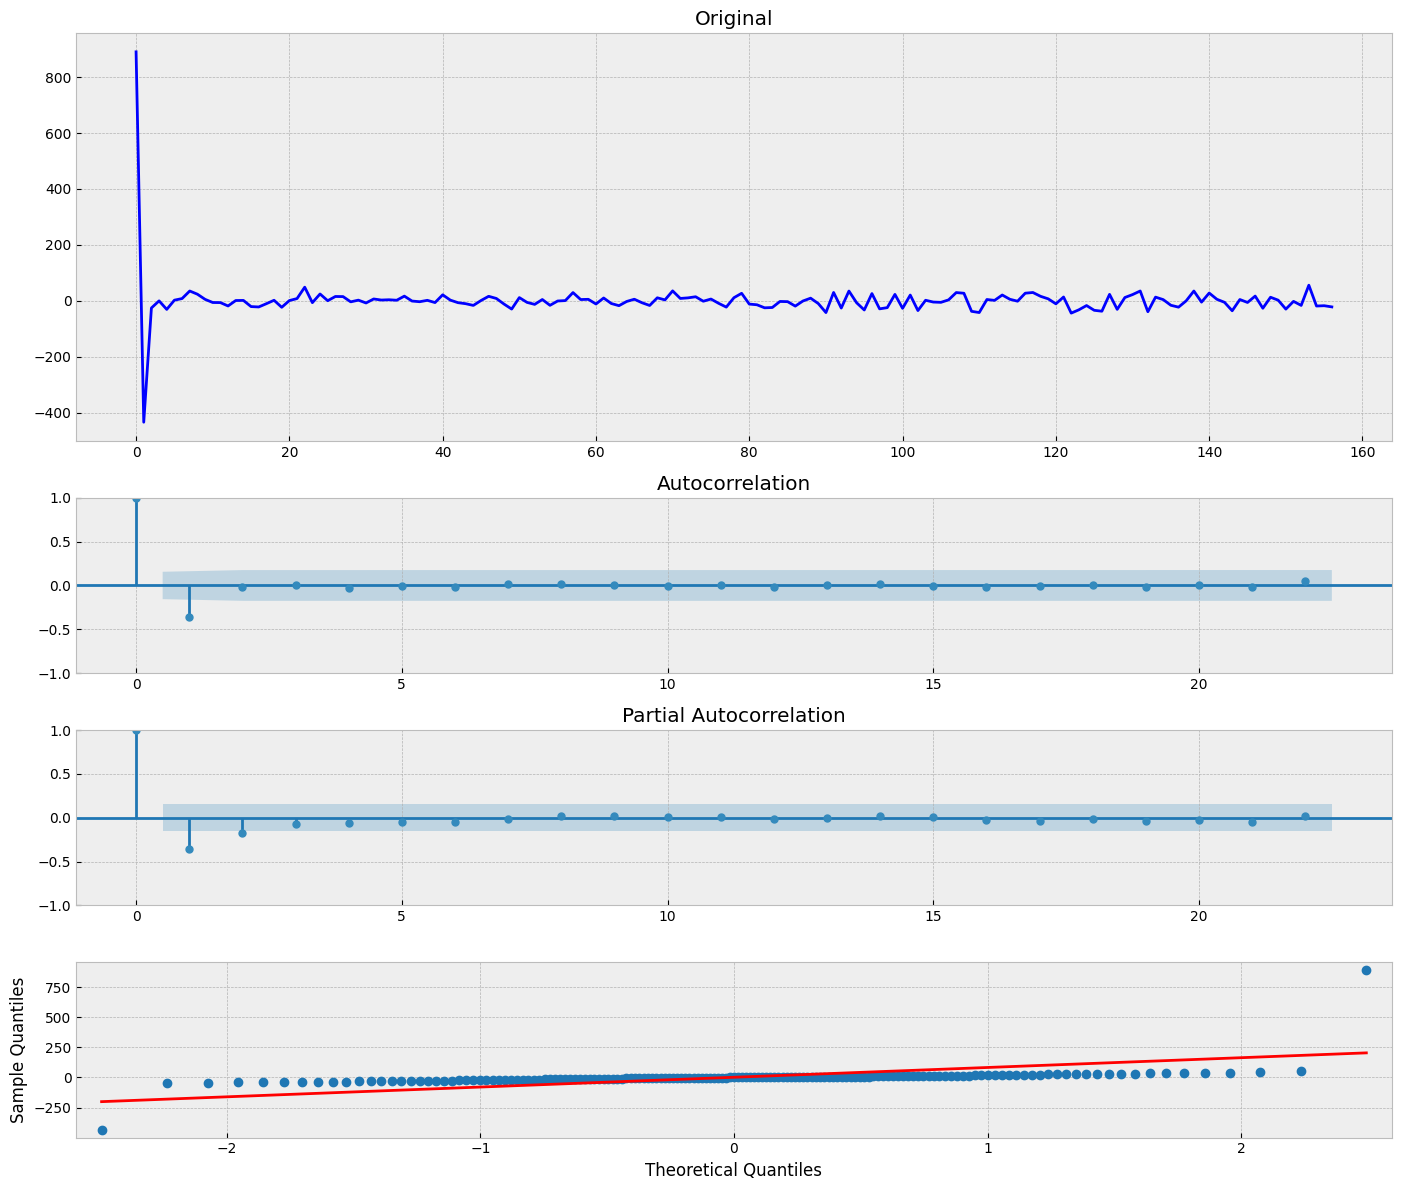

In [15]:
tsplot(best_mdl.resid)

### Кроме распределения на последнем графике остальные графики и p-value отвечают критериям стационарности.  

**Вывод:** Эта модель не даёт надёжного предсказания далее 2-3 точек, поэтому, возможно, необходимо делать ре-моделинг после каждой новой фактической точки.

### Проверим ради интереса, какй будет результат в применении к ряду после приведения его к стационарности способом из 1 лекции:

In [16]:
series = boxcox(data, 0)
series = np.diff(series, 1)

## Проверка на стационарность: Тест Дики-Фуллера 

In [17]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


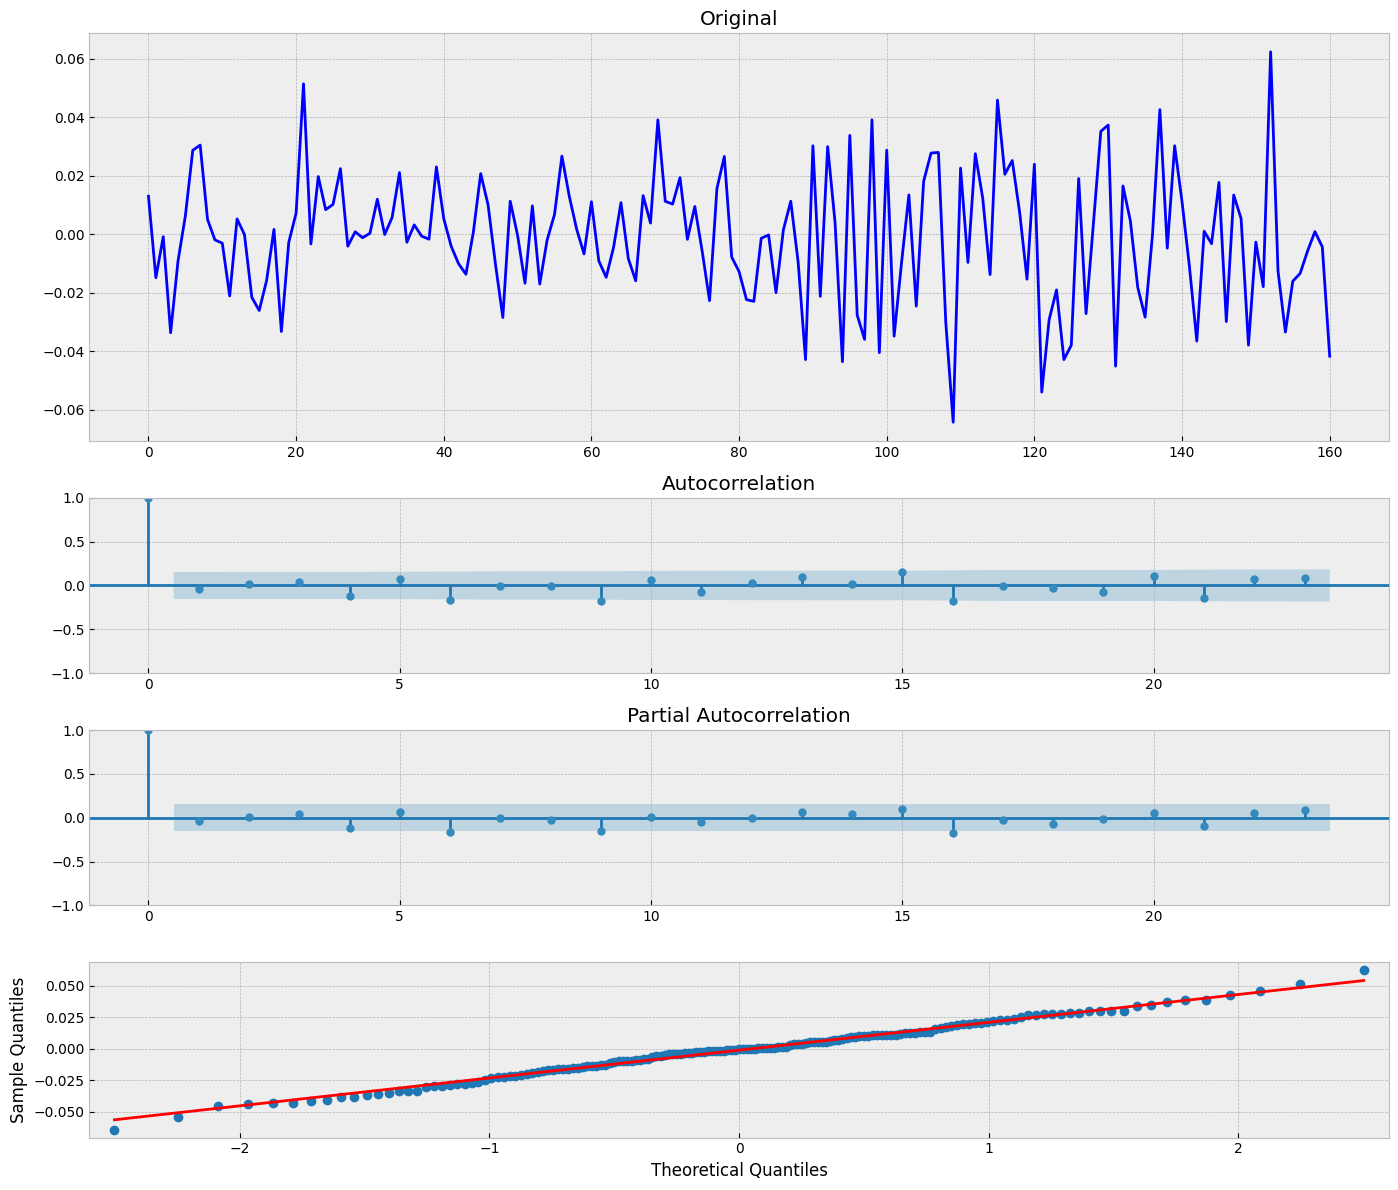

In [18]:
tsplot(series)

In [19]:
series = pd.DataFrame(series)

In [20]:
train_data = series[:len(series)-5]
test_data = series[len(series)-5:]

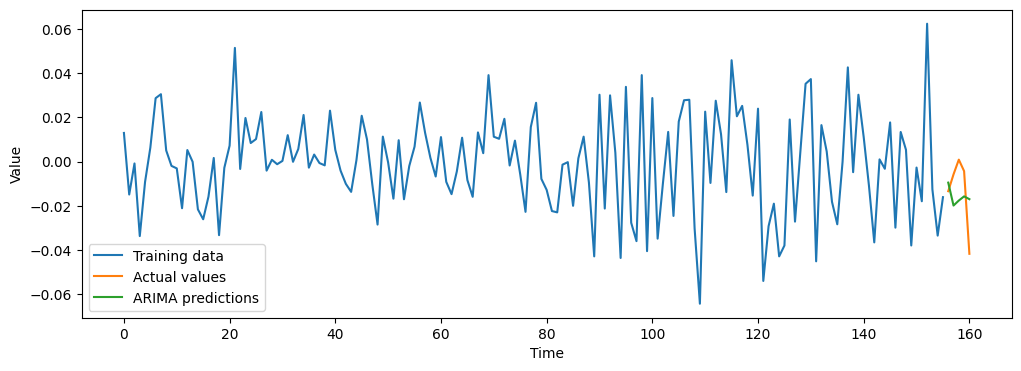

In [21]:
model = ARIMA(train_data, order = (3,2,1))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end = len(train_data)+len(test_data)-1)

plt.figure(figsize=(12,4))
plt.plot(train_data, label='Training data')
plt.plot(test_data.index, test_data, label='Actual values')
plt.plot(test_data.index, predictions, label='ARIMA predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [22]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(7):
    for d in range(7):
        for j in range(7):
            try:
                tmp_mdl = ARIMA(train_data, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -741.33995 | order: (0, 0, 0)


### Как и можно было ожидать модель Arima после приведения к стационарности ряда не даёт значимого результата, хотя кривая достигает некоторого среднего значения, предсказанного моделью со значениями (0, 0, 0).

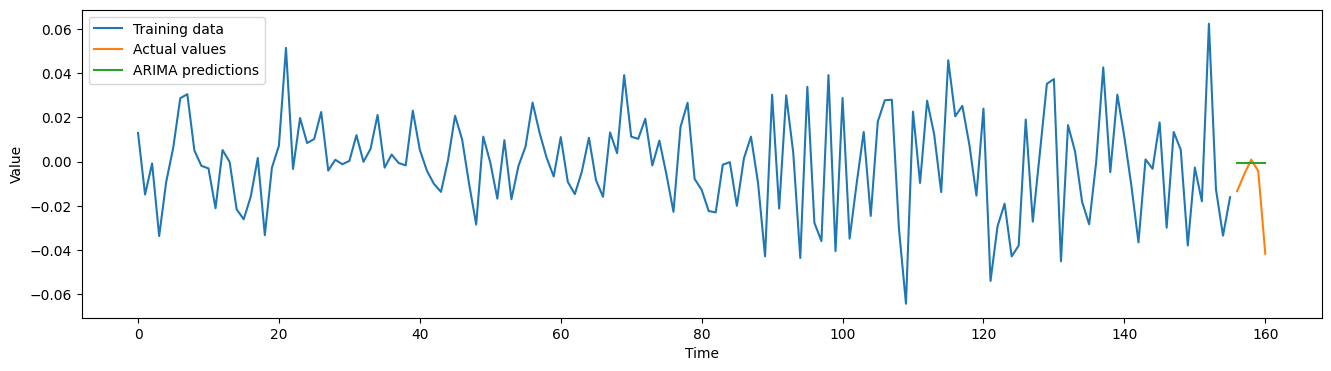

In [23]:
model = ARIMA(train_data, order = best_order)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end = len(train_data)+len(test_data)-1)

plt.figure(figsize=(16,4))
plt.plot(train_data, label='Training data')
plt.plot(test_data.index, test_data, label='Actual values')
plt.plot(test_data.index, predictions, label='ARIMA predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()